# Validation Example

There are many ways to validate a model with scalecast and this notebook introduces them and overviews the differences between dynamic and non-dynamic tuning/testing, backtesting, and fitted values.

- Download data: https://www.kaggle.com/robervalt/sunspots  
- See here for EDA on this dataset: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html  
- See here for documentation on cross validation: https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.cross_validate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster

In [2]:
sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
def prepare_fcst(f, test_length=0.1, fcst_length=120):
    """ adds all variables and sets the test length/forecast length in the object
    
    Args:
        f (Forecaster): the Forecaster object.
        test_length (int or float): the test length as a size or proportion.
        fcst_length (int): the forecast horizon.
        
    Returns:
        (Forecaster) the processed object.
    """
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(f.test_length)
    f.add_seasonal_regressors("month", raw=False, dummy=True)
    for i in np.arange(60, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_seasonal_regressors("year")
    return f


def export_results(f):
    """ returns a dataframe with all model results given a Forecaster object.
    
    Args:
        f (Forecaster): the Forecaster object.
        
    Returns:
        (DataFrame) the dataframe with the pertinent results.
    """
    results = f.export("model_summaries", determine_best_by="TestSetMAE")
    results["N_Xvars"] = results["Xvars"].apply(lambda x: len(x))
    return results[
        [
            "ModelNickname",
            "TestSetRMSE",
            "InSampleRMSE",
            "ValidationMetric",
            "ValidationMetricValue",
            "HyperParams",
            "TestSetLength",
            "ValidationSetLength",
            "Tuned",
            "CrossValidated",
            "DynamicallyTested",
        ]
    ]

## Load Forecaster Object
- we choose 120 periods (10 years) for all validation and forecasting
- 10 years of observervations to tune model hyperparameters, 10 years to test, and a forecast horizon of 10 years

In [4]:
df = pd.read_csv("Sunspots.csv", index_col=0, names=["Date", "Target"], header=0)
f = Forecaster(y=df["Target"], current_dates=df["Date"])
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=120
    Xvars=['month_1', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'A

In [5]:
f.set_estimator("gbt")

In the [feature_selection](https://scalecast-examples.readthedocs.io/en/latest/misc/feature-selection/feature_selection.html) notebook, gbt was chosen as the best model class out of several tried. We will show all examples with this estimator.

## Default Model Parameters
- one with dynamic testing
- one with non-dynamic testing
- the difference can be expressed by taking the case of a simple autoregressive model, such that:


### Non-Dynamic Autoregressive Predictions

$$
x_t = \alpha * x_{t-1} + e_t
$$

Over an indefinite forecast horizon, the above equation would only work if you knew the value for $x_{t-1}$. Going more than one period into the future, you would stop knowing what that value is. In a test-set of data, of course, you do know all values into the forecast horizon, but to be more realistic, you could write an equation for a two-step forecast like this:

### Dynamic Autoregressive Predictions

$$
\hat{x_t} = \hat{\alpha} * x_{t-1}
$$
$$
x_{t+1} = \hat{\alpha} * \hat{x}_t + e_{t+1}
$$

Using these two equations, which scalecast refers to as dynamic forecasting, you could evaluate any forecast horizon by plugging in predicted values for $x_{t-1}$ or ${x_t}$ over periods in which you did not know it. This is default behavior for all models tested through scalecast, but it is not default for tuning models. We will explore dynamic tuning soon. First, let's see in practical terms the difference between non-dynamic and dynamic testing.

In [6]:
f.manual_forecast(call_me="gbt_default_non-dynamic", dynamic_testing=False)
f.manual_forecast(call_me="gbt_default_dynamic")  # default is dynamic testing

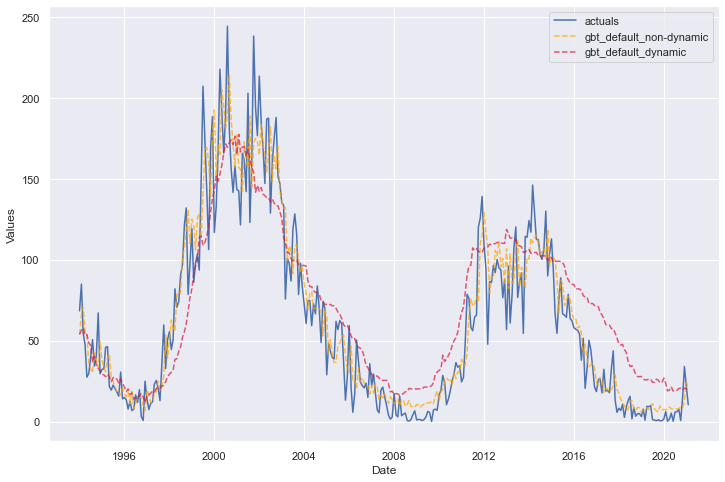

In [7]:
f.plot_test_set(
    models=["gbt_default_non-dynamic", "gbt_default_dynamic"], include_train=False
)
plt.show()

It appears that the non-dynamically tested model performed significantly better than the other, but looks can be deceiving. In essence, the non-dynamic model was only tested for its ability to perform 326 one-step forecasts and its final metric is an average of these one-step forecasts. It could be a good idea to set `dynamic_testing=False` if you want to speed up the testing process or if you only care about how your model would perform one step into the future. But to report the test-set metric from this model as if it could be expected to do that well for the full 326 periods into the future is misleading. The other model that was dynamically tested can be more realistically trusted in that regard.

In [8]:
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,ValidationSetLength,Tuned,CrossValidated,DynamicallyTested
0,gbt_default_non-dynamic,18.807696,18.841733,None,None,{},326,None,False,False,False
1,gbt_default_dynamic,27.084496,18.841733,None,None,{},326,None,False,False,True


## Tune the model to find optimal hyperparameters
- create a validation grid
- try three strategies to tune the parameters:
  - train/validation/test split
    - hyperparameters are tried on the validation set
  - train/test split with 5-fold time-series cross-validation on training set
    - training data split 5 times into train/validations set
    - models trained on training set only
    - validated out-of-sample
    - all data available before each validation split sequentially used to train the model
  - train/test split with 5-fold time-series rolling cross-validation on training set
    - rolling is different in that each train/validation split is the same size
- use dynamic testing and tuning on all these models
  - dynamic tuning is not default behavior for scalecast because it uses loops and therefore slows the tuning process significantly. but, it is necessary to find the best hyperparameters in this example because of the data's complexity.

In [9]:
grid = {
    "max_depth": [2, 3, 5, None],
    "max_features": ["sqrt", "auto"],
    "subsample": [0.8, 0.9, 1],
}

In [10]:
f.ingest_grid(grid)

### Train/Validation/Test Split
- the data's sequence is maintained in time-series splits

![](./mermaid-diagram-20220614194220.png)

In [11]:
f.tune(dynamic_tuning=True)
f.auto_forecast(
    call_me="gbt_tuned"
)  # automatically uses optimal paramaeters suggested from the tuning process

In [12]:
f.export_validation_grid("gbt_tuned").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value
8,3.0,sqrt,1.0,326,rmse,39.799993
7,3.0,sqrt,0.9,326,rmse,42.290635
12,5.0,sqrt,0.8,326,rmse,51.101542
9,3.0,auto,0.8,326,rmse,55.832748
1,2.0,sqrt,0.9,326,rmse,56.174060
10,3.0,auto,0.9,326,rmse,59.794607
14,5.0,sqrt,1.0,326,rmse,62.913262
2,2.0,sqrt,1.0,326,rmse,65.013121
6,3.0,sqrt,0.8,326,rmse,67.389554
5,2.0,auto,1.0,326,rmse,73.782894


### 5-Fold Time Series Cross Validation
- split training set into k (5) folds
- each validation set is the same size and determined such that: `val_size = n_obs // (folds + 1)`
  - the last training set will be the same size or almost the same size as the validation sets
- model trained and re-trained with all data that came before each validation slice
- each fold tested out of sample on its validation set
- final error is an average of the out-of-sample error obtained from each fold
- the chosen hyperparameters are determined by which final error was minimized
- below is an example with a dataset sized 100 observations and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

![](./cv.png)

The final error, *E*, can be expressed as an average of the error from each fold *i*: 
$$
E = \frac{1}{n}\sum_{i=0}^{n-1}{(e_i)}
$$

In [13]:
f.cross_validate(k=5, dynamic_tuning=True)
f.auto_forecast(call_me="gbt_cv")

In [14]:
f.export_validation_grid("gbt_cv").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value,fold,rolling,train_length
38,2.0,sqrt,1.0,449,rmse,40.232903,2,False,1592
52,5.0,auto,0.9,449,rmse,49.849281,2,False,1592
46,3.0,auto,0.9,449,rmse,51.242028,2,False,1592
47,3.0,auto,1.0,449,rmse,51.320299,2,False,1592
40,2.0,auto,0.9,449,rmse,52.564955,2,False,1592
18,2.0,sqrt,0.8,449,rmse,52.916035,1,False,2041
39,2.0,auto,0.8,449,rmse,53.696020,2,False,1592
49,5.0,sqrt,0.9,449,rmse,53.863679,2,False,1592
42,3.0,sqrt,0.8,449,rmse,54.509712,2,False,1592
41,2.0,auto,1.0,449,rmse,54.858786,2,False,1592


### 5-Fold Rolling Time Series Cross Validation
- split training set into k (5) folds
- each validation set is the same size
- each training set is also the same size as each validation set
- each fold tested out of sample
- final error is an average of the out-of-sample error obtained from each folds
- the chosen hyperparameters are determined by which final error was minimized
- below is an example with a dataset sized 100 observation and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

![](./rolling_cv.png)

In [15]:
f.cross_validate(k=5, rolling=True, dynamic_tuning=True)
f.auto_forecast(call_me="gbt_rolling_cv")

In [16]:
f.export_validation_grid("gbt_rolling_cv").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value,fold,rolling,train_length
50,5.0,sqrt,1.0,449,rmse,47.270506,2,True,449
38,2.0,sqrt,1.0,449,rmse,48.915053,2,True,449
45,3.0,auto,0.8,449,rmse,49.041246,2,True,449
42,3.0,sqrt,0.8,449,rmse,52.419814,2,True,449
49,5.0,sqrt,0.9,449,rmse,52.498947,2,True,449
52,5.0,auto,0.9,449,rmse,52.596605,2,True,449
44,3.0,sqrt,1.0,449,rmse,53.424326,2,True,449
36,2.0,sqrt,0.8,449,rmse,53.660099,2,True,449
48,5.0,sqrt,0.8,449,rmse,53.985724,2,True,449
51,5.0,auto,0.8,449,rmse,55.171890,2,True,449


### View results

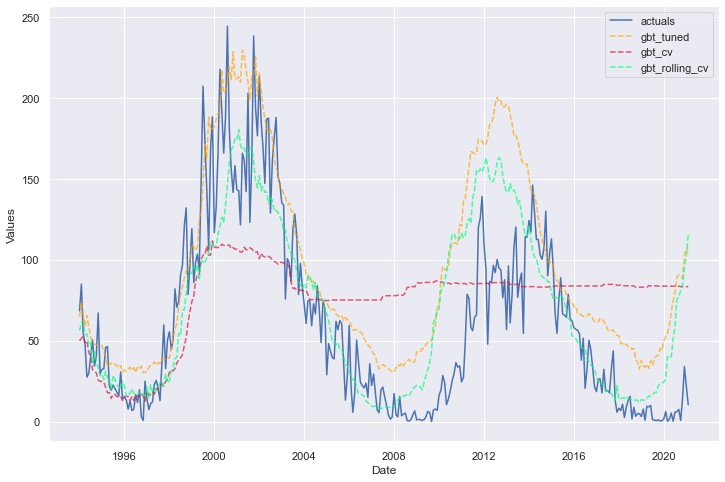

In [17]:
f.plot_test_set(
    models=["gbt_tuned", "gbt_cv", "gbt_rolling_cv"], include_train=False,
)
plt.show()

In [18]:
pd.set_option('max_colwidth', 60)
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,ValidationSetLength,Tuned,CrossValidated,DynamicallyTested
0,gbt_default_non-dynamic,18.807696,18.841733,None,None,{},326,None,False,False,False
1,gbt_default_dynamic,27.084496,18.841733,None,None,{},326,None,False,False,True
2,gbt_rolling_cv,36.469432,12.969052,rmse,71.789825,"{'max_depth': 5, 'max_features': 'sqrt', 'subsample': 1}",326,None,Dynamically,True,True
3,gbt_tuned,46.577010,20.305833,rmse,39.799993,"{'max_depth': 3, 'max_features': 'sqrt', 'subsample': 1}",326,326,Dynamically,False,True
4,gbt_cv,52.123829,21.628234,rmse,64.615717,"{'max_depth': 2, 'max_features': 'auto', 'subsample': 1}",326,None,Dynamically,True,True


In the above comparison, the validation metric values will vary depending on how each model was tuned. What is important is comparing the test-set metric, which none of the models saw during their various validation processes. Using that metric, the rolling-cv technique performed about as well as the default model. We should ignore the model that was not dynamically tested because its test-set metric is artificially low. Let's choose the gbt with rolling cross validation as the best model.

## Backtest best model
- backtesting is a process in which the final chosen model is re-validated by seeing its average performance on the last x-number of forecast horizons available in the data
- all forecasating is dynamic in this process to give a true sense of the model's performance on a forecast horizon of that size
- all error metrics are for level data, even if the data in the object was differenced
- in this example, we test the best-performing model on the last-15 120-period forecasts
- see the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.backtest) for more information

In [19]:
best_model = "gbt_rolling_cv"
f.backtest(best_model, n_iter=15, fcst_length=120)
f.export_backtest_metrics(best_model)

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,iter11,iter12,iter13,iter14,iter15,mean
RMSE,21.664768,20.946316,19.998522,19.166126,21.689255,19.793089,26.813933,24.036086,18.359566,18.658395,17.458924,26.900784,19.015425,19.972934,21.151647,21.041718
MAE,16.628732,16.648099,15.80401,14.237552,16.911402,14.529093,21.916158,18.974296,13.732897,14.672874,12.737918,21.571895,14.527486,15.482274,16.177769,16.303497
R2,0.735494,0.751429,0.773246,0.791716,0.731884,0.774091,0.582357,0.66207,0.801811,0.794027,0.819236,0.566928,0.781176,0.757248,0.725894,0.736574
MAPE,2.45361,3.557871,1.296327,1.026351,1.550926,1.252462,2.806979,1.822176,1.884079,1.700938,0.682636,1.652285,1.3297,1.263586,1.211223,1.699410


On average, we can expect this model to have an RMSE of 21, MAE of 16, and R2 of 74% over a full 120-period forecast window. That is significantly better than what our test set suggested, but our test set was significantly larger than our forecast horizon, so it makes sense. An extension of this analysis would be to choose our Xvars more carefully (see [here](https://scalecast-examples.readthedocs.io/en/latest/misc/feature-selection/feature_selection.html)) and to use more complex models (see [here](https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html)).

## The Eye Test

In addition to all the objective validation performed in this notebook, one of the most important questions to ask is if the forecast looks reasonable. Does it pass the common sense test? Below, we plot the 120-forecast period horizon from the best model.

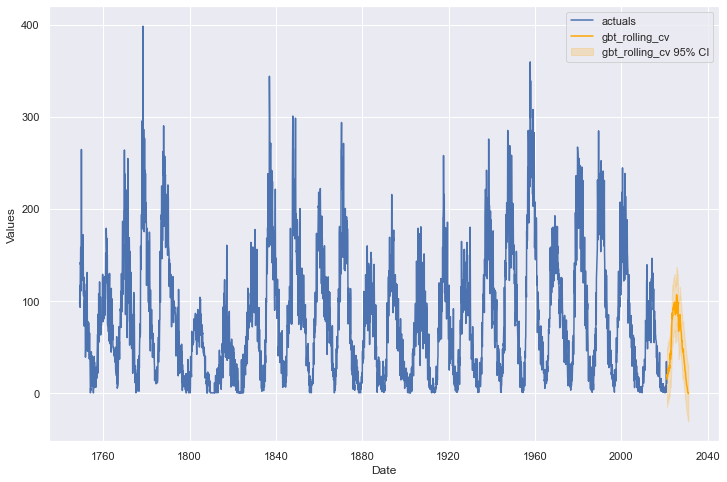

In [23]:
f.plot(models=best_model, ci = True)
plt.show()